In [49]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression , SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve
import joblib 

In [2]:
data = pd.read_csv("mnist_train.csv")
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


In [4]:
y = data["label"].to_numpy()
y

array([5, 0, 4, ..., 5, 6, 8], shape=(60000,))

In [5]:
X = data.drop(axis = 1, columns = "label").to_numpy()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(60000, 784))

In [6]:
data.shape

(60000, 785)

In [7]:
np.random.seed(42)
random_idx = np.random.randint(0,784)
some_x = X[random_idx]
some_x_reshaped = some_x.reshape(28,28)
y[random_idx]


np.int64(1)

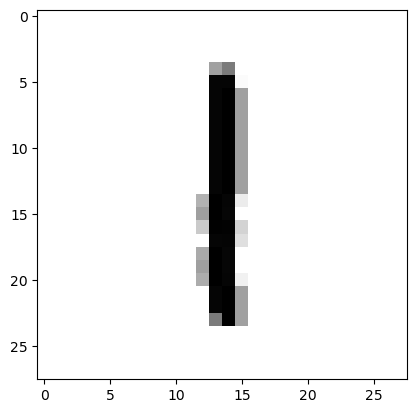

In [8]:
plt.imshow(some_x_reshaped,cmap = 'binary' )

In [9]:
y_train_5 = y == 5
y_train_5

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In [10]:


models = {'logistic regression' : make_pipeline(StandardScaler(),LogisticRegression(random_state = 42, max_iter = 5000)),
           'SGD Classifier' :  make_pipeline(StandardScaler(),SGDClassifier(random_state = 42)),
           'Random Forest' : RandomForestClassifier(random_state = 42)}
for name, model in models.items():
    scores = cross_val_score(model,X,y_train_5,cv = 5,scoring= 'accuracy')
    print(f"{name} : score = {scores} \n mean score = {scores.mean()}")
 
    

logistic regression : score = [0.97608333 0.9725     0.97383333 0.9725     0.97591667] 
 mean score = 0.9741666666666667
SGD Classifier : score = [0.973      0.97008333 0.96858333 0.96716667 0.96933333] 
 mean score = 0.9696333333333333
Random Forest : score = [0.99033333 0.98816667 0.98808333 0.9865     0.98675   ] 
 mean score = 0.9879666666666667


 prediction count for logistic regression = 60000



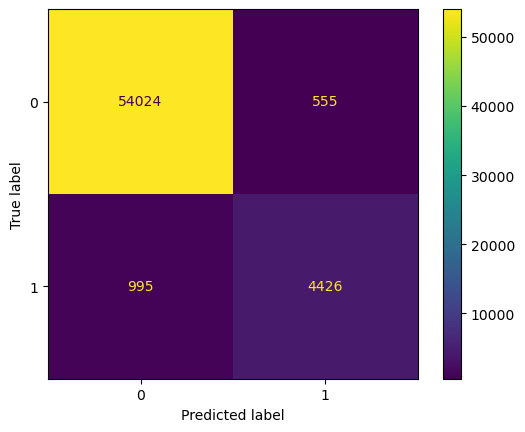

 prediction count for SGD Classifier = 60000



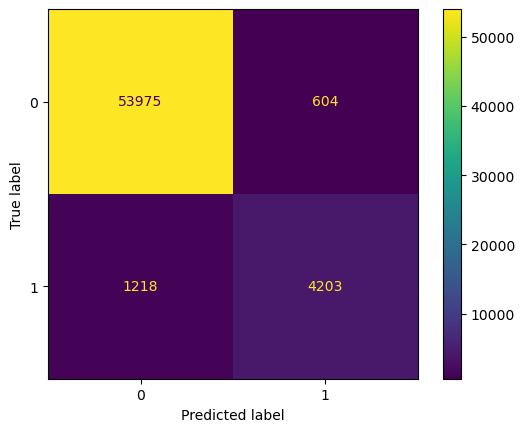

 prediction count for Random Forest = 60000



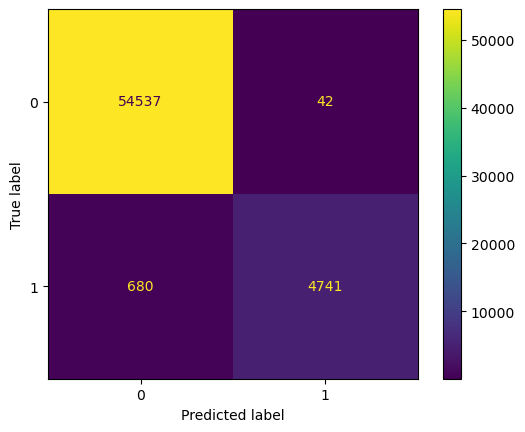

In [16]:
for name, model in models.items():
    predictions = cross_val_predict(model,X,y_train_5,cv = 5)
    print(f" prediction count for {name} = {predictions.size}\n")
    cf_marix = confusion_matrix(y_train_5,predictions)
    cfMatrixDisp = ConfusionMatrixDisplay(cf_marix)
    cfMatrixDisp.plot()
    plt.show()
    

# Random Forest is the Clear Winner

In [18]:
rf_pred = cross_val_predict(models["Random Forest"], X, y_train_5, cv = 5)
precision = precision_score(y_train_5, rf_pred)
recall = recall_score(y_train_5, rf_pred)
f1 = f1_score(y_train_5,rf_pred)
print(f" precision = {precision}\nrecall = {recall}\nf1 score = {f1}")

 precision = 0.9912189002717959
recall = 0.8745618889503781
f1 score = 0.9292434339474716


In [19]:
final_model = RandomForestClassifier(random_state= 42)
final_model.fit(X,y_train_5)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
param_dist = {
    'n_estimators': randint(100, 500),  
    'max_features': ['sqrt', 'log2'],  
    'max_depth': randint(10, 50),      
}

In [27]:
random_search = RandomizedSearchCV(models["Random Forest"],param_dist,cv = 3,verbose = 2,random_state=42,n_jobs=-1, scoring='precision')
random_search.fit(X,y_train_5)
random_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


,n_estimators,413
,criterion,'gini'
,max_depth,42
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [31]:
final_model = random_search.best_estimator_
pred = cross_val_predict(final_model,X,y_train_5,cv  = 5, method = 'predict_proba',verbose = 2,)
precision, recall, threshold = precision_recall_curve(y_train_5,pred[:,1])

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished


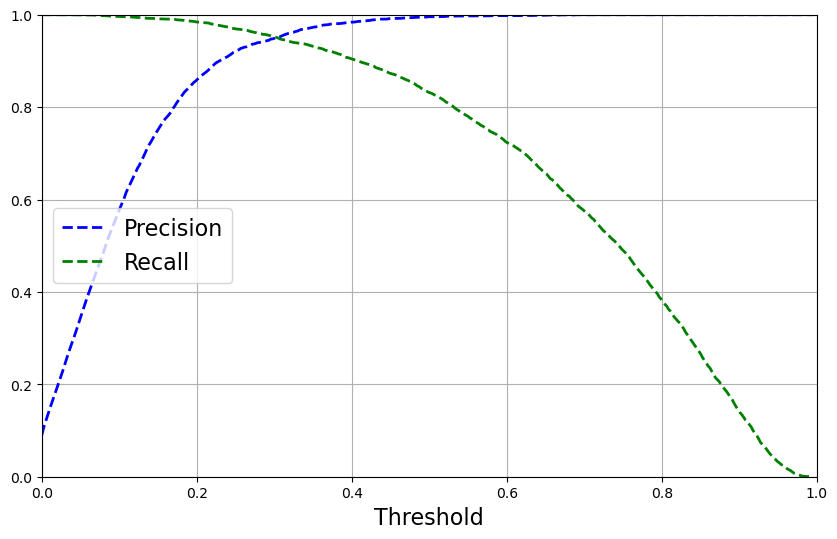

In [33]:
plt.figure(figsize = (10,6))
plt.plot(threshold,precision[:-1],"b--",label="Precision",linewidth = 2)
plt.plot(threshold,recall[:-1],"g--",label="Recall",linewidth = 2)
plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="center left", fontsize=16)
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.show()

# Going for high precision 

In [35]:
index_99precision = np.argmax(precision >= 0.99)
final_threshold = threshold[index_99precision]

In [37]:
print(f" at threshold {final_threshold} we will get recall = {recall[index_99precision]} and precision = {precision[index_99precision]}")

 at threshold 0.4358353510895884 we will get recall = 0.8826784726065302 and precision = 0.9900682805710739


In [38]:
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
test_data = pd.read_csv("mnist_test.csv")
X_test = test_data.drop(columns = "label", axis = 1).to_numpy()
y_test = test_data["label"]
y_test_5 = y_test == 5 

0    False
1    False
2    False
3    False
4    False
Name: label, dtype: bool

In [48]:
test_pred = final_model.predict_proba(X_test)[:,1]
y_test_custom_threshold = test_pred >= final_threshold
print("--- Custom Threshold Results ---")
print(f"Accuracy:  {accuracy_score(y_test_5, y_test_custom_threshold):.4f}")
print(f"Precision: {precision_score(y_test_5, y_test_custom_threshold):.4f}") 
print(f"Recall:    {recall_score(y_test_5, y_test_custom_threshold):.4f}")

--- Custom Threshold Results ---
Accuracy:  0.9887
Precision: 0.9924
Recall:    0.8800


In [51]:
filename = "mnist_model_is_5_precision_99.pkl"
joblib.dump(final_model,filename)
print(f" model saved in {filename}")

 model saved in mnist_model_is_5_precision_99.pkl
